# ResNet Architecture

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Add, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform, constant
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

### ResNet model

In [11]:
# residual block

def bottleneck_residual_block(x, kernel_size, filters, reduce=False, s=1):
    f1, f2, f3 = filters
    x_shortcut = x

    if reduce:
        x_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=(s, s), padding='same', activation=relu)(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

        x = Conv2D(filters=f1, kernel_size=(1, 1), strides=(s, s), padding='same')(x)
        x = BatchNormalization(axis=3)(x)
        x = Activation(relu)(x)
    else:
        # first component of the main path
        x = Conv2D(filters=f1, kernel_size=(1, 1), strides=(s, s), padding='valid')(x)
        x = BatchNormalization(axis=3)(x)
        x = Activation(relu)(x)

    # second component of the main path
    x = Conv2D(filters=f2, kernel_size=kernel_size, strides=(s, s), padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation(relu)(x)

    # third component of the main path
    x = Conv2D(filters=f3, kernel_size=(1, 1), strides=(s, s), padding='same')(x)
    x = BatchNormalization(axis=3)(x)

    x = Add()([x, x_shortcut])
    x = Activation(relu)(x)

    return x

In [12]:
def ResNet50(input_shape, classes):
    x_input = Input(input_shape)

    # stage 1
    x = Conv2D(filters=64, kernel_size=(3, 3), name='conv1')(x_input)
    x = BatchNormalization(axis=3)(x)
    x = Activation(relu)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # stage 2
    x = bottleneck_residual_block(x, kernel_size=3, filters=[64, 64, 256], reduce=True)
    x = bottleneck_residual_block(x, kernel_size=3, filters=[64, 64, 256])
    x = bottleneck_residual_block(x, kernel_size=3, filters=[64, 64, 256])

    # stage 3
    x = bottleneck_residual_block(x, kernel_size=3, filters=[128, 128, 256], reduce=True)
    x = bottleneck_residual_block(x, kernel_size=3, filters=[128, 128, 256])
    x = bottleneck_residual_block(x, kernel_size=3, filters=[128, 128, 256])
    x = bottleneck_residual_block(x, kernel_size=3, filters=[128, 128, 256])

    # stage 4
    x = bottleneck_residual_block(x, kernel_size=3, filters=[256, 256, 1024], reduce=True)
    x = bottleneck_residual_block(x, kernel_size=3, filters=[256, 256, 1024])
    x = bottleneck_residual_block(x, kernel_size=3, filters=[256, 256, 1024])
    x = bottleneck_residual_block(x, kernel_size=3, filters=[256, 256, 1024])
    x = bottleneck_residual_block(x, kernel_size=3, filters=[256, 256, 1024])
    x = bottleneck_residual_block(x, kernel_size=3, filters=[256, 256, 1024])

    # stage 5
    x = bottleneck_residual_block(x, kernel_size=3, filters=[512, 512, 2048], reduce=True)
    x = bottleneck_residual_block(x, kernel_size=3, filters=[512, 512, 2048])
    x = bottleneck_residual_block(x, kernel_size=3, filters=[512, 512, 2048])

    # AVG POOL
    x = AveragePooling2D(pool_size=(1, 1))(x)

    # output layer
    x = Flatten()(x)
    x = Dense(units=1024, activation=relu)(x)
    x = Dense(units=1024, activation=relu)()
    x = Dense(units=classes, activation=sigmoid)(x)

    model = Model(x_input, x, name='ResNet50')

    return model

In [13]:
exp_conv = ResNet50(input_shape=(56,56,3), classes=36)

ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [7]:
exp_conv.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 54, 54, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_53 (BatchN  (None, 54, 54, 64)  256         ['conv1[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 activation_49 (Activation)     (None, 54, 54, 64)   0           ['batch_normalization_53[0

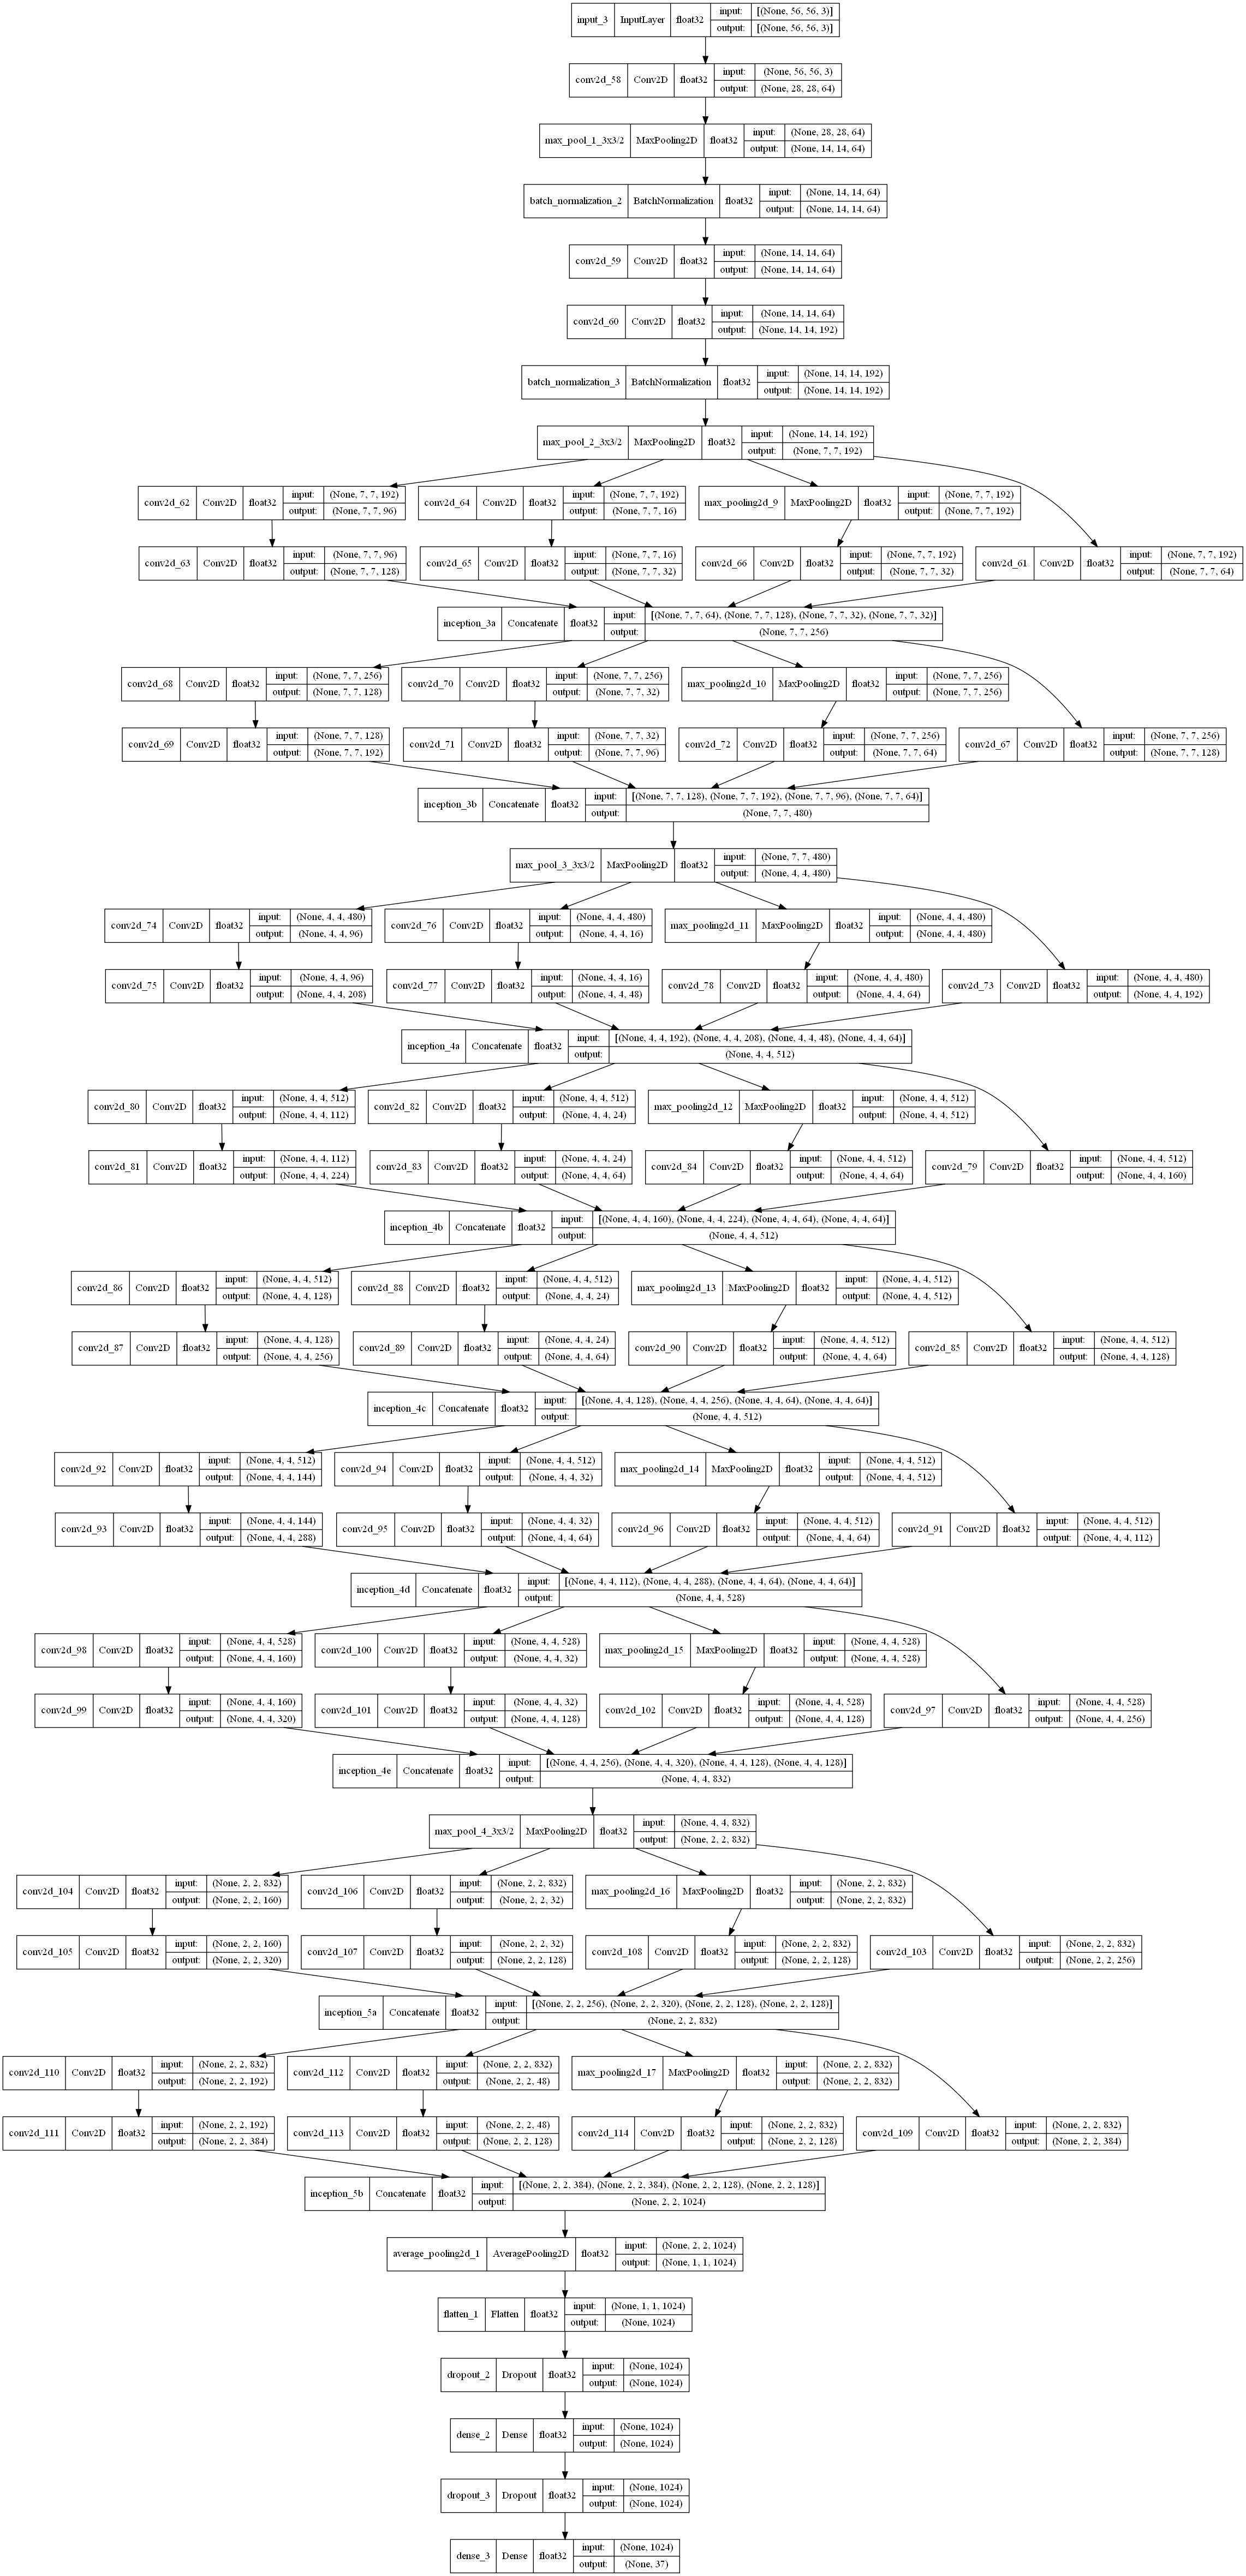

In [13]:
plot_model(model=exp_conv,
           to_file='ResNet.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [5]:
tree_types = os.listdir('../../data/image data/train')
X = []
y = []
val_x = []
val_y = []

for tree in tree_types:
    if not tree == 'Cassava':
        tree_path = os.path.join('../../data/image data/train', tree)
        tree_disease_types = os.listdir(tree_path)

        for disease in tree_disease_types:
            img_name = os.listdir(os.path.join(tree_path, disease))

            for img in img_name:
                image_path = os.path.join(tree_path, disease, img)
                image = img_to_array(load_img(image_path, target_size=(56, 56)))
                X.append(image)
                y.append([tree, disease])

for tree in tree_types:
    if not tree == 'Cassava':
        tree_path = os.path.join('../../data/image data/validation', tree)
        tree_disease_types = os.listdir(tree_path)

        for disease in tree_disease_types:
            img_name = os.listdir(os.path.join(tree_path, disease))

            for img in img_name:
                image_path = os.path.join(tree_path, disease, img)
                image = img_to_array(load_img(image_path, target_size=(56, 56)))
                val_x.append(image)
                val_y.append([tree, disease])


In [6]:
X = np.asarray(X)
val_x = np.asarray(val_x)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
generator = ImageDataGenerator(rescale=1. / 255)

In [7]:
X.shape, y.shape, val_x.shape, val_y.shape

((36531, 56, 56, 3), (36531, 37), (9112, 56, 56, 3), (9112, 37))

In [8]:
train_gen = generator.flow(X, y, batch_size=64)
val_gen = generator.flow(val_x, val_y, batch_size=64)

#### training

In [9]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1)

check_point = ModelCheckpoint(filepath='ResNet.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stopping]

In [14]:
exp_conv.compile(optimizer=Adam(),
                 loss=binary_crossentropy,
                 metrics=['accuracy'])

In [ ]:
exp_conv_history = exp_conv.fit(train_gen,
                                epochs=200,
                                callbacks=callbacks,
                                validation_data=val_gen)

Epoch 1/200
286/286 [==============================] - 98s 311ms/step - loss: 0.1502 - accuracy: 0.1785 - val_loss: 0.2072 - val_accuracy: 0.1298 - lr: 0.0010
Epoch 2/200
286/286 [==============================] - 86s 300ms/step - loss: 0.0855 - accuracy: 0.3266 - val_loss: 0.0922 - val_accuracy: 0.3335 - lr: 0.0010
Epoch 3/200
286/286 [==============================] - 89s 312ms/step - loss: 0.0547 - accuracy: 0.3742 - val_loss: 0.0486 - val_accuracy: 0.3602 - lr: 0.0010
Epoch 4/200
286/286 [==============================] - 85s 299ms/step - loss: 0.0396 - accuracy: 0.3980 - val_loss: 0.0766 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 5/200
286/286 [==============================] - 88s 307ms/step - loss: 0.0313 - accuracy: 0.4205 - val_loss: 0.0634 - val_accuracy: 0.4516 - lr: 0.0010
Epoch 6/200
286/286 [==============================] - 88s 306ms/step - loss: 0.0252 - accuracy: 0.4195 - val_loss: 0.1757 - val_accuracy: 0.3613 - lr: 0.0010
Epoch 7/200
286/286 [=========================

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(exp_conv_history.history['loss'])))

sns.lineplot(x=epochs, y=exp_conv_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=exp_conv_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=exp_conv_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=exp_conv_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('ResNet_train_history.png')
plt.show()

In [ ]:
figure_1, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=exp_conv_history.history['lr'], ax=axes[0], label='learning rate')
sns.lineplot(x=exp_conv_history.history['lr'], y=exp_conv_history.history['val_accuracy'], ax=axes[1],
             label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('ResNet_lr_history.png')
plt.show()